# Neural Networks and Learning Machines

## ANN Exercise 2 - Natural Language Processing (NLP)

Natural Language Processing (NLP) is a set of techniques and algorithms that use computers for analyzing natural human language.  NLP can be used to solve a variety of problems, for example:

* Subject Matter Identification - What are the topics, people, companies or places discussed in this text?
* Sentiment Analysis - Does this text convey a positive, negative or neutral feeling about an entity or subject matter?
* Machine Translation - Convert the input from one language to another, for example, from English to French
* Text-to-Speech - Convert the spoken input into its written form
* Understanding and Interpretation - What information will answer a specific question?

This exercise will teach you the basics of NLP using neural networks, focusing on text classification.
First you will learn a few common ways to encode/embed text as vectors/matrices such that a neural network can use it as an input.
Then you'll use those embeddings in order to embed a dataset of texts and classify them.
Finally you'll learn how to use some more advanced neural networks models in order to generate text.

Before you get started you'll also need to download the file 'wiki.simple.vec' from Canvas, which contains word embeddings that will be used in this exercise. Do **NOT** include 'wiki.simple.vec' in your submission of this exercise.

### Literature

The following sections in the [course book](https://www.deeplearningbook.org/) are relevant for this exercise.
* 12.4 - Natural Language Processing
   - (more subsection details as far from every subsection of NLP is useful to the course)

Optional reading for more details on RNNs:
* 10 - Sequence Modeling: Recurrentand Recursive Nets

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchtext.datasets import AG_NEWS
from sklearn.metrics import confusion_matrix
import torchtext
import matplotlib.pyplot as plt
import numpy
import random
import gensim

## 1. Turning sentences into matrices

As you know a neural network can only process numbers, so anything we want to process with a neural networks needs to be encoded (embedded) into number, aka vectors.
We've technically already done this for images in exercise 0 and ANN1 where we encoded the images of handwritten digits as numbers representing the grayscale value of each pixel.
For images this process was intuitive as we're already used to representing pixels as numbers, but how do you do this for text?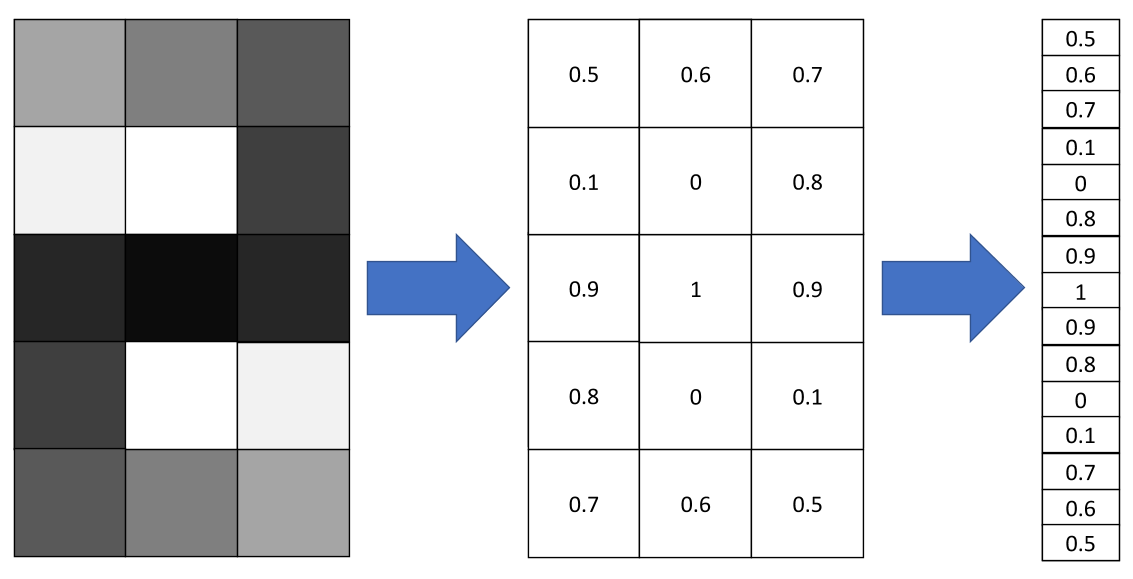

There are many different ways to encode text for neural network applications. You can replace each letter by their position in the alphabet, you can replace each word by their position in some dictionary, you can create complex vectors that distribute words in some N-dimensional space, etc, etc.
Most encodings of text is done on the word level, since we know that we want to use words anyways and learning to create words from letters turns out to be quite challenging ('runes' and 'nurse' contain the exact same letters but mean very different things).

In this exercise we will learn to create and use two types of embeddings:
* Bag of Words (BoW)
* Word2Vec (Skip-gram)

We will also learn about another Word2Vec implementation called Continuous Bag of Words (CBoW), and you may implement this as well as an optional task.
 
Finally we will also learn to use pretrained embeddings, where you simply use embeddings created by someone else.

Before we can start with each embedding, we have to discuss the so-called preprocessing pipeline.
The preprocessing pipeline is simply all the step we take from raw data (text) to the input of our neural networks.
There are many ways to form such a pipeline, with many different optional steps to add on, but generally it consists of some or all of the following parts:
* Cleaning - Removing unnecessary/unimportant parts of the text (like making all letters lowercase, removing special characters, etc)
   - Example: "Does Michael like 99 cats?" $\rightarrow$ "does michael like 99 cats"
* Tokenization - Splitting the text into its constituent parts (like words, letters, and/or symbols depending on what embedding you use)
   - Example: "does michael like 99 cats" $\rightarrow$ \["does", "michael", "like", "99", "cats"\]
* Stemming/lemmatization - Switch all words into their baseform (like removing plural, changing verbs to their root form, etc)
   - Example: \["does*", "michael", "like", "99", "cats"\] $\rightarrow$ \["do", "michael", "like", "99", "cat"\]
* Replace rare/special tokens - Switch some rare (only shows up once or twice in the dataset) or special (names, numbers, etc) tokens for tags
   - Example: \["do", "michael", "like", "99", "cat"\] $\rightarrow$ \["do", "\<NAME\>", "like", "\<NUMBER\>", "cat"\]
* Indexing - Create a token to number mapping and replace each token by its number
   - Example: \["do", "\<NAME\>", "like", "\<NUMBER\>", "cat"\] $\rightarrow$ \[454, 3, 872, 2, 234\]
* Embedding - Use an embedder to get a vector to use as input to the machine learning model.

This might seem overwhelming but there are a lot of toolkits that will help you with these steps.
This might also seem like we're getting rid of a lot of useful data, and that's true but often having well-formatted data is better than having more data.
In the end it depends from problem to problem which preprocessing steps are best.
For this exercise you will only need to think of tokenizing, indexing, and embedding.
The AG News dataset have already been tokenized and indexed, but you will need to create a tokeizer and indexer for the "cat on the mat" dataset.

### Datasets

In this exercise we will use two text datasets the "cat on the mat"-dataset and the [AG News dataset](https://www.kaggle.com/amananandrai/ag-news-classification-dataset). The code for creating/downloading both datasets are provided below. The former dataset is a small dummy dataset we will use to visulize and understand the methods. AG News is a large dataset of excerpts from news articles from a few different topics that can be used to train, for example, a news classifier.

#### "Cat on the mat"-dataset

In [50]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
animal_corpus = [f'the {x[0]} {x[1]} on the {x[2]}' for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print(f'There are {len(animal_corpus)} sentences in the corpus, with a vocabulary of {vocabulary_size} words')
print(f'The first sentence in the corpus is "{animal_corpus[0]}"')

#print(animal_corpus)


There are 128 sentences in the corpus, with a vocabulary of 18 words
The first sentence in the corpus is "the cat sat on the mat"


#### AG News dataset

In [3]:
## Download,tokenize, and index the AG News dataset
# This is done in a separate cell as indexing takes some time

ag_train, ag_test = AG_NEWS(ngrams=1, vocab=None, root='data')

120000lines [00:04, 28135.82lines/s]
120000lines [00:08, 14673.36lines/s]
7600lines [00:00, 14455.19lines/s]


In [4]:
# Our labels are numbers, here's what type of article they represent
ag_labels = {
    0 : 'World',
    1 : 'Sports',
    2 : 'Business',
    3 : 'Sci/Tec'
}

# vocab is a class that will give us the index for any given word/token (vocab['hi'] = <some number>)
vocab = ag_train.get_vocab()

# nr2word is a list that contains the actual tokens for a given index (nr2word[5678] = <some word/token>)
nr2word = vocab.itos

# Let's make a function that takes an entire tensor and returns the string version of that tensor
def tensor2text(tensor):
    return ' '.join([nr2word[index] for index in tensor])

# And a function to turn text into the indexed version (though it won't work with special characters)
def text2tensor(text):
    tensor = torch.Tensor([vocab[token] for token in text.split(' ')])
    return tensor.int()

# And let's see what the dataset actually contains
ag_train_len = len(ag_train) #Get the number of entries in the AG_NEWS dataset

print(
    f'ag_train contains {len(ag_train)} labelled text snippets '
    f'and has a vocabulary size of {len(vocab)}\n'
    f'On index 0, ag_train contains:\n{ag_train[0]}\n'
    f'which has the label {ag_train[0][0]} that translates into "{ag_labels[ag_train[0][0]]}" '
    f'and the text snippet itself translates into:\n{tensor2text(ag_train[0][1])}'
)

ag_train contains 120000 labelled text snippets and has a vocabulary size of 95812
On index 0, ag_train contains:
(2, tensor([  432,   426,     2,  1606, 14839,   114,    67,     3,   849,    14,
           28,    15,    28,    16, 50726,     4,   432,   375,    17,    10,
        67508,     7, 52259,     4,    43,  4010,   784,   326,     2]))
which has the label 2 that translates into "Business" and the text snippet itself translates into:
wall st . bears claw back into the black ( reuters ) reuters - short-sellers , wall street ' s dwindling\band of ultra-cynics , are seeing green again .


## Tokenizing and Indexing
This new corpus of texts needs to be tokenized and indexed before we can start using it.
The tokenizer only needs to be able to handle this simple dataset, so it can be fairly simple.

**Exercise 1.1:** Write a tokenizer and an vocabulary class with a function that will give you the index of a token, and a function that will give you the token at a certain index.


In [5]:
def simple_tokenizer(text):
    '''
    Takes a text and returns a list of the individual words
    Args:
        text (str): The text to tokenize
    Returns ([str]): A list of individual words
    '''
    ## WRITE A TOKENIZER (Hint: use the 'split' function)
    #return ...
    tokenized_items = text.split()
    return tokenized_items

class SimpleVocabulary():
    
    def __init__(self, corpus):
        '''
        Takes a corpus, tokenizes it, and sets the internal variables needed
        to return the index of any given word (and what word has a given index)
        Args:
            corpus ([str]): The corpus as a list of non-tokenized texts
        '''
        ## WRITE A FUNCTION TO INITIALIZE THE VOCABULARY
        # HINT: Create a dictionary that contains the index for each unique word and antother to
        # contain the word for a given index
        # HINT: Each new, previously unseen token from the tokenized corpus,
        # should be entered into the dictionaries
        
        
        current_index = 0
        self.token2index = {}
        self.index2token = []
        for contents in corpus:
            tokenized_items = simple_tokenizer(contents)
            for token in tokenized_items:
                if self.get_index(token) == None:
                    self.token2index[token] = current_index
                    self.index2token.append(token)
                    current_index+=1
    
    def get_index(self, token):
        '''
        Takes a token and returns the index of that token
        Args:
            token (str): A token
        Returns (int): The index of the given token
        '''
        ## WRITE A FUNCTION THAT RETURNS THE INDEX OF A GIVEN TOKEN
        return self.token2index.get(token,None)
    

    def get_token(self, index):
        '''
        Takes an index and returns the token that index represents
        Args:
            index (int): An index
        Returns (str): The token that the given index represents
        '''
        ## WRITE A FUNCTION THAT RETURNS THE TOKEN OF A GIVEN INDEX
        return self.index2token[index]

    
    def __len__(self):
        '''
        Returns (int): The number of words in the vocabulary
        '''
        ## WRITE A FUNCTION THAT RETURNS THE LENGTH OF THE VOCABULARY
        return len(self.index2token)
    
def index_sequence(sequence, vocabulary):
    '''
    Takes a tokenized text and a vocabulary and returns an indexed sequence
    Args:
        sequence ([str]): A list of individual tokens
    Returns ([int]): A list of indexes
    '''
    
    return [vocabulary.get_index(token) for token in sequence]
    

**Check your solution**: The code cell below will try to tokenize and index a few sentences

In [6]:
animal_vocab = SimpleVocabulary(animal_corpus)
test_sequence = 'the cat stood on the mat'
tokenized_sequence = simple_tokenizer(test_sequence)
print(tokenized_sequence)
indexed_sequence = index_sequence(tokenized_sequence, animal_vocab)
print(indexed_sequence)
assert len(tokenized_sequence) == 6, 'The tokenized sequence should contain all words of the original sequence'
assert len(tokenized_sequence) == len(indexed_sequence), 'The indexed sequence should be as long as the tokenized sequence'
assert indexed_sequence[0] == indexed_sequence[4], 'The index of the same word should be the same'
assert len(animal_vocab) >= 18, 'There should be at least 18 words in the vocabulary (more if you have a out-of-vocabulary token/index)'
print('simple_tokenizer and SimpleVocabulary seems to be properly implemented!')

['the', 'cat', 'stood', 'on', 'the', 'mat']
[0, 1, 8, 3, 0, 4]
simple_tokenizer and SimpleVocabulary seems to be properly implemented!


## Bag of Words (BoW)

Bag of Words is often seen as the default way to embed text as it is very easy to do.
In bag of words each text is represented as a N-dimensional vector, where N is the number of words in the vocabulary.
Each word in the vocabulary is given an index and each text is represented by a vector where the index of each word contains the number of occurences of this word in the text.
For example if we have the vocabulary \["the", "cat", "dog", "sat", "on", "mat", "sofa"\] then the text "the cat sat on the mat" would be represented by the BoW vector \[2, 1, 0, 1, 1, 1, 0\]
Simply put, each text is represented by the by stuffing all of its words into a bag, without care for their order.
While getting rid of the order of words might seem distastrous ("I do like candy" and "do I like candy" doesn't mean the same thing), this simple approach can still be enough to tackle many problems.
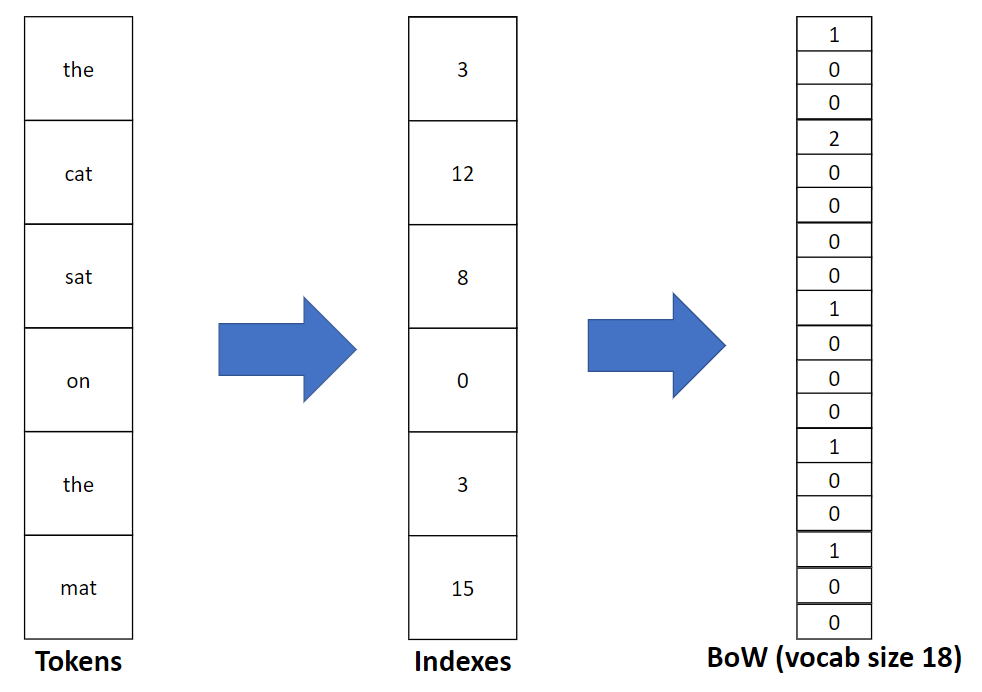

**Exercise 1.2**: Make a BoW embedder that takes the tensor (index vector) representation of a text, the length of the vocabulary, and returns a Bag of Words representation. How sparse are the vectors (how many zero/nonzero elements are there)? Why is this the case?

In [7]:
def bow_embedder(tensor, vocab_length):
    '''
    Takes a tensor and a vocabulary and returns the BoW embedding of that tensor
    Args:
        tensor (torch.Tensor): A tensor of words represented by their index in the vocabulary
        vocab_lenght (int): The number of entries in the vocabulary
    Returns (torch.Tensor): An tensor containing the BoW embedding of the input tensor
    '''
    ## ADD CODE HERE
    tensor_internal = tensor.long()
    bow_embed = torch.zeros(vocab_length)
    
    for i in tensor:
        bow_embed[i] += 1
    return bow_embed


**Check your solution**: The code cell below will try to embed a few sentences using your embedder and will check that the embeddings seem correct.

In [8]:
vocab_length = len(vocab)

sentence_1 = 'the cat dances well for a little while'
sentence_2 = 'for a while the little cat dances well'
sentence_3 = 'the dog sits for a while'
sentence_4 = 'the cat and the dog'

sentence_1_indexed = text2tensor(sentence_1)
sentence_2_indexed = text2tensor(sentence_2)
sentence_3_indexed = text2tensor(sentence_3)
sentence_4_indexed = text2tensor(sentence_4)

sentence_1_bow = bow_embedder(sentence_1_indexed, vocab_length)
sentence_2_bow = bow_embedder(sentence_2_indexed, vocab_length)
sentence_3_bow = bow_embedder(sentence_3_indexed, vocab_length)
sentence_4_bow = bow_embedder(sentence_4_indexed, vocab_length)

# Assert statements are mainly used to test code
# You give them a statement that should be True and they throw an error if it doesn't
assert isinstance(sentence_1_bow, torch.Tensor), 'The BoW embedding should be a tensor'
assert len(sentence_1_bow) == vocab_length, 'The length of the BoW embedding should be the same as the vocabulary'
assert torch.all(sentence_1_bow == sentence_2_bow), 'Texts with the exact same words should have the same BoW embedding'
assert torch.any(sentence_1_bow != sentence_3_bow), 'Texts with different words should have different BoW embeddings'
assert sum(sentence_1_bow) == len(sentence_1_indexed), 'The sum of the BoW embedding should be the number of words in the text'
assert max(sentence_4_bow) == 2, 'A BoW embeddings should count the number of occurances of each word'

print('The bow_embedder seems to be properly implemented!')

The bow_embedder seems to be properly implemented!


#### Visualizing BoW

Before we use our embedder to train an actual neural network on the AG News dataset, let's see what it looks like using our smaller "cat on the mat"-dataset.

In [46]:
## Let's take a sentence and create the BoW representation for it
animal_vocab = SimpleVocabulary(animal_corpus) # Create vocabulary
test_sequence = 'the cat stood on the mat' # Create the sentence
tokenized_sequence = simple_tokenizer(test_sequence) # Tokenize the sentence
indexed_sequence = torch.Tensor(index_sequence(tokenized_sequence, animal_vocab)) #Index the sentence and turn it into a tensor
bow_sequence = bow_embedder(indexed_sequence.long(), len(animal_vocab)) # Create the BoW embedding of the sentence

print(f'The sentence \n"{test_sequence}"\nwas embedded with the BoW representation \n{bow_sequence}\n')

The sentence 
"the cat stood on the mat"
was embedded with the BoW representation 
tensor([2., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])



### Training a news text classifier

So now that we have a way to embed our sentences, let's use that to train a classifier on the AG News dataset.

**Exercise 1.3**: Create a neural network and the train and test loops, and get at least 80% accuracy on the test set. 



In [45]:
# We create our own dataset to load the BoW embedded texts
class BoWDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], len(vocab))
  
    def __len__(self):
        return len(self.dataset)

In [11]:
bow_train_data = BoWDataset(ag_train, bow_embedder)
bow_test_data = BoWDataset(ag_test, bow_embedder)
bow_trainloader = DataLoader(bow_train_data, batch_size=1000, shuffle=True)
bow_testloader = DataLoader(bow_test_data, batch_size=1000, shuffle=False)

## CREATE A NEURAL NETWORK TO TRAIN
#network = nn.Sequential(
#    ... # HINT: We want our input to be the size of our BoW embedding and our output to be the different possible classes
#)

network = nn.Sequential(
                        nn.Linear(len(vocab), 100),
                        nn.ReLU(),
                        nn.Linear(100, len(ag_labels))
                        )


# Use for instance Adam
optimizer = torch.optim.Adam(network.parameters(), lr = 0.1)

# What loss function works well when we have different classes?
loss_function = nn.CrossEntropyLoss()

epochs = 1 # The dataset is large so one epoch should do for our purpose (and anything more would take forever)

for epoch in range(epochs):
    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (labels, data) in enumerate(bow_trainloader):
       ## WRITE TRAINING CODE HERE
       #...
    

        # Predict for each BoW represented text in the batch what class they belong to
        prediction = network(data)
        
        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction, labels)
        
        # Backpropagate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()
        
        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(bow_trainloader)}] - Loss: {loss}',
            end=''
        )



Epoch 1 [120/120] - Loss: 0.26227822899818425

In [12]:
print(labels)

tensor([0, 2, 3, 3, 0, 1, 0, 2, 1, 0, 1, 0, 3, 0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 1,
        2, 3, 0, 3, 0, 2, 3, 1, 3, 2, 2, 3, 3, 0, 3, 3, 1, 1, 2, 0, 1, 1, 3, 2,
        3, 1, 2, 1, 0, 1, 2, 3, 2, 0, 2, 2, 3, 0, 2, 3, 1, 1, 1, 1, 1, 1, 0, 2,
        3, 3, 1, 3, 1, 2, 2, 0, 1, 3, 2, 0, 2, 2, 1, 0, 3, 1, 2, 1, 2, 1, 2, 1,
        0, 2, 1, 2, 1, 2, 1, 3, 0, 3, 0, 0, 1, 3, 2, 0, 3, 0, 3, 2, 3, 1, 2, 0,
        2, 1, 3, 1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 1, 3, 3, 3, 1, 3, 2, 3, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 1, 3, 3, 3, 2, 0, 2, 0, 3, 0, 0, 1,
        3, 3, 0, 1, 2, 0, 1, 1, 0, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 2, 2, 1, 2, 3,
        2, 0, 1, 2, 0, 3, 1, 0, 1, 3, 2, 1, 1, 0, 0, 1, 2, 3, 1, 3, 2, 2, 3, 0,
        2, 0, 0, 0, 2, 0, 2, 0, 3, 3, 3, 1, 2, 3, 1, 1, 3, 3, 3, 3, 1, 2, 2, 2,
        3, 0, 1, 3, 2, 0, 1, 1, 1, 0, 3, 0, 2, 0, 2, 1, 3, 0, 1, 0, 1, 0, 3, 3,
        2, 3, 2, 2, 3, 0, 2, 1, 2, 0, 0, 3, 3, 0, 1, 3, 0, 1, 2, 1, 0, 2, 2, 0,
        1, 0, 2, 1, 0, 1, 0, 1, 3, 1, 2,

We should analyse the performance of our network besides the loss. Let's calculate the accuracy and the confusion matrix.

**Exercise 1.4**: Calculate accuracy and the confusion matrix using predictions from the test set. Feel free to use the code for confusion matrix computation and visualisation provided below.



In [48]:
with torch.no_grad():
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy
    for batch_nr, (labels, data) in enumerate(bow_testloader):
        ## WRITE THE TESTING CODE HERE
        ...
        prediction2 = network(data)
        prediction3 = list(prediction.argmax() for prediction in prediction2)
        correct += numpy.equal(prediction3, labels).sum().item()
        total += len(prediction3)
        y_pred += prediction3
        y_true += labels
        
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x95812 and 300x100)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1736   52   56   56]
 [  24 1858    7   11]
 [  67   15 1563  255]
 [  51   15   57 1777]]


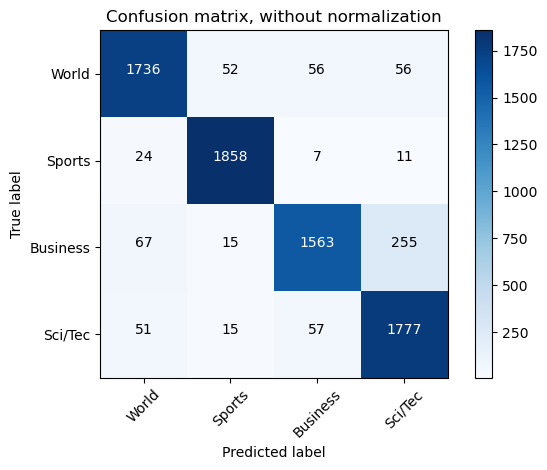

In [15]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')

In [16]:
# Let's print a sentence and predict it's category
sentence_index = 0
prediction = torch.argmax(network(torch.unsqueeze(bow_embedder(ag_train[sentence_index][1], len(vocab)), dim=0))).item()
print(
    f'The network predicted that \n"{tensor2text(ag_train[sentence_index][1])}"\n should be in the category {ag_labels[prediction]}'
)

The network predicted that 
"wall st . bears claw back into the black ( reuters ) reuters - short-sellers , wall street ' s dwindling\band of ultra-cynics , are seeing green again ."
 should be in the category Business


## 2. Word2Vec

As you might already have thought BoW embeddings have a few problems.
Firstly, it diregards the order of words which, as previously stated, can be quite important.
Secondly, the size of the embedding grows larger with the size of the vocabulary.
While the second issue can be solved by limiting the vocabulary to the most common/important words, this remains a fairly large vector with very few non-zero elements (a sparse vector).

One commonly used alternative that fixes both of these issues is the so-called Word2Vec embeddings.
Word2Vec can be summarized as using machine learning to learn non-sparse (most, if not all, entries are non-zero) word embeddings with fewer dimensions (typically between 100 and 1000). A text is then represented as a matrix where the first row (or column depending on how you use it) represents the first word and so on.
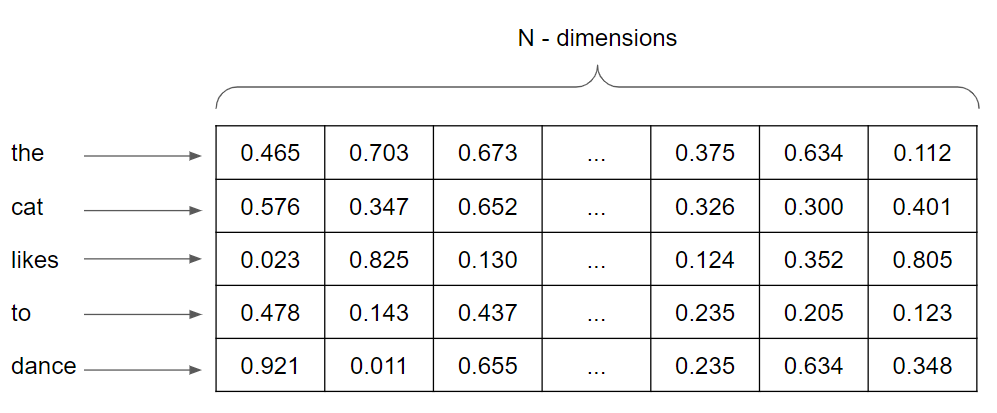

So how do you learn an embedding?
Again, there are many ways to do this, but the most common Word2Vec methods use the idea that a word is defined by the company it keeps.
That is, an embedding of a word is good if you can either use it to predict which the surrounding words are or if it can be predicted using the surrounding words.
So you either train a model to predict the surrounding words from the central word, or train it to predict a word from the surrounding ones.
These two methods are called Skip-Gram and Continuous Bag of Words (CBoW) respectively and are illustrated by the images below.

<h1><center>Skip-gram</center></h1>| <h2><center>CBoW</center></h2>
- | -
<img src="attachment:image-3.png" width="300"> | <img src="attachment:image-2.png" width="300">

The logic behind these methods can be better understood by imagining synonyms.
If we're creating embeddings (codes) to represent different words, it makes sense that similar words should have similar embeddings.
Since synonymous words would have many similar surrounding words in many sentences, telling the difference between the two would be difficult, and thus giving them similar embeddings would lead to a lesser error.
However, words that have slightly different meaning cannot have the same embeddings, because that would make predicting words from that embedding more difficult.

While training useful such embeddings for every single words takes huge datasets of texts, this only has to be done once and then those embeddings can be used for many different applications.
Due to this time consuming training we will only train a very small sample of word embeddings to learn how it's done and better understand them.
Afterwards we will use pretrained embeddings to do some actual prediction.

With this in mind we will use the "cat on the mat" dataset to train our embeddings.
Our goal is to create embeddings where each group of words (animals, furniture, actions, and other) are given distinct groups in the encoding space.

### Skip-gram embedding

In Skip-gram embeddings we want to predict the surrounding words from a given one.
Rather than for a given word predicting all the surrounding words at once, we'll create context-target pairs.
We decide on a window size, and create a context target pair with the central word being the context and each word in the window of surrounding words will be our target. 
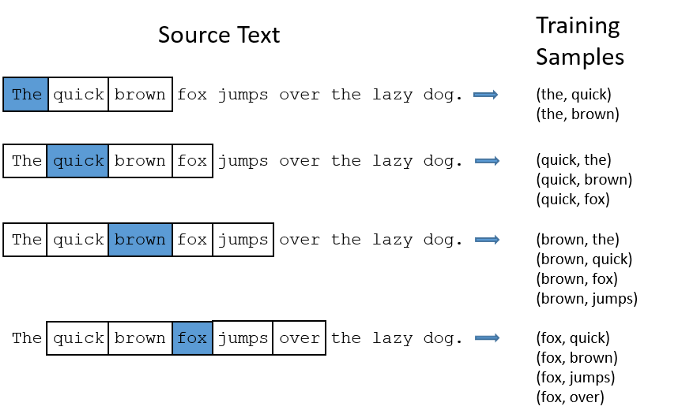

The goal of the training is to predict the target word given the context word.
We provide the function for creating context-target pairs below, so you don't need to implement this yourself.

We'll use these context-target pairs to train a neural network to predict the target word and, hopefully, during this training the hidden layer of the neural network will become the embedding of our context word.
So in order to get the embedding after training, we simply input a word and extract the values of the hidden layer of the network

In [17]:
## Hyperparameters for Skip-gram Embedding
WINDOW_SIZE = 2
EMBEDDING_SIZE = 2

In [18]:
# This is code for the skipgram generation (you don't need to understand it)
def skipgrams(sequences, window_size = 2, shuffle = True):
    couples = []
    for sequence in sequences:
        for i, wi in enumerate(sequence):
    
            window_start = max(0, i - window_size)
            window_end = min(len(sequence), i + window_size + 1)
            for j in range(window_start, window_end):
                if j != i:
                    wj = sequence[j]
                    couples.append([wi, wj])

    if shuffle:
        seed = random.randint(0, 10e6)
        random.shuffle(couples)

    return torch.Tensor(couples)

In [19]:
# We print the path from text to skip-grams so you can see the process

animal_vocab = SimpleVocabulary(animal_corpus)
test_sequence = 'the cat stood on the mat'
print('The sentence:',test_sequence)
tokenized_sequence = simple_tokenizer(test_sequence)
print('The sentence split into tokens:',tokenized_sequence)
indexed_sequence = [animal_vocab.get_index(token) for token in tokenized_sequence]
print('The indexed sentence:', indexed_sequence)
skipgrams_sequence = skipgrams([indexed_sequence], shuffle=False).int()
print('All generated skip-gram pairs:', skipgrams_sequence)
skipgrams_sequence_words = [(animal_vocab.get_token(x[0]), animal_vocab.get_token(x[1])) for x in skipgrams_sequence]
print('The skip-gram pairs as text:', skipgrams_sequence_words)

The sentence: the cat stood on the mat
The sentence split into tokens: ['the', 'cat', 'stood', 'on', 'the', 'mat']
The indexed sentence: [0, 1, 8, 3, 0, 4]
All generated skip-gram pairs: tensor([[0, 1],
        [0, 8],
        [1, 0],
        [1, 8],
        [1, 3],
        [8, 0],
        [8, 1],
        [8, 3],
        [8, 0],
        [3, 1],
        [3, 8],
        [3, 0],
        [3, 4],
        [0, 8],
        [0, 3],
        [0, 4],
        [4, 3],
        [4, 0]], dtype=torch.int32)
The skip-gram pairs as text: [('the', 'cat'), ('the', 'stood'), ('cat', 'the'), ('cat', 'stood'), ('cat', 'on'), ('stood', 'the'), ('stood', 'cat'), ('stood', 'on'), ('stood', 'the'), ('on', 'cat'), ('on', 'stood'), ('on', 'the'), ('on', 'mat'), ('the', 'stood'), ('the', 'on'), ('the', 'mat'), ('mat', 'on'), ('mat', 'the')]


In [20]:
# We create the actual skip-gram pairs for the entire "cat on the mat"-dataset

animal_vocab = SimpleVocabulary(animal_corpus)
indexed_text = [[animal_vocab.get_index(token) for token in simple_tokenizer(text)] for text in animal_corpus]
pairs = skipgrams(indexed_text, WINDOW_SIZE)
print(f'There are {len(pairs)} pairs of skip-grams created from the "cat in the mat" dataset.')

There are 2304 pairs of skip-grams created from the "cat in the mat" dataset.


For creating the skipgram embedding we will not use nn.Sequential as we usually do when creating neural networks.
Instead we will create a subclass of nn.Module to create our own PyTorch module.
This is useful when we need to create neural networks with non-linear structure, or with some quirk that cannot be implemented with existing modules.
In short a nn.Module needs only a single function called 'forward' that takes the input and performs the forward pass of the network using differentiable functions (most torch functions and mathematical operations supports this).
Any part of the module that needs to be initialized (like nn.Linear) needs to be so in the \_\_init\_\_ function of the network after the super().\_\_init\_\_() statement.
In this exercise you will not need to write the \_\_init\_\_ function.
For more information on creating networks as subclasses of nn.Module, read **[here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module)**.

**Exercise 2.1**: Create the SkipgramEmbedder class, a neural network that first reduces the one-hot embedding of one word to a smaller embedding space and then predicts the one-hot embedding of the paired word using that. These embeddings should then be such that most groups of words are separate on the embedding space (though if two groups overlaps that is fine). Think of why the groups gets embedded the way they do.

In [21]:
# An Embedding layer used for turning int into one-hot
to_onehot = nn.Embedding.from_pretrained(torch.eye(len(animal_vocab))) 

class SkipgramEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(len(animal_vocab), EMBEDDING_SIZE)
        self.output_layer = nn.Linear(EMBEDDING_SIZE, len(animal_vocab))
        self.softmax = nn.Softmax()
    
    def embed(self, context_index):       
        # IMPLEMENT THE EMBEDDING STEP OF THE SKIP-GRAM EMBEDDER
        context_onehot = to_onehot(context_index) # Make a one-hot representation of the index
        embedding = self.input_layer(context_onehot) # Pass the one-hot representation throught the first layer to create an embedding
        return embedding
    
    def forward(self, context_index):
        # IMPLEMENT THE FORWARD PASS FOR PREDICTING TARGET WORD FROM THE CONTEXT WORD
        embedding = self.embed(context_index) # Use the self.embed function
        output = self.output_layer(embedding) # Pass the embedding through the second layer to create an output
        prediction = self.softmax(output) # Pass the output through softmax 
        return prediction
        


#### Learing the embeddings
Run the code below to train your embedder so it learns the embeddings

**Exercise 2.2:** Implement a network that trains your embedder by predicting targets based on context.

**Hint**: The code for training is very similar to exercise 1.3, but we now need to use *pairs* to extract the current contexts for prediction and targets for evaluation, and some way of keeping track of indexes. 

In [22]:
model = SkipgramEmbedder()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

#Epochs
TOTAL_EPOCHS = 1000
BATCH_SIZE = len(pairs)
EMBEDDING_SIZE = 100
# For each epoch
for epoch in range(TOTAL_EPOCHS):
    # 
    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0
    # 
    # Lower index
    start = 0
    # 
    # For each batch
    for batch_nr, end in enumerate(range(BATCH_SIZE,len(pairs),BATCH_SIZE)):
        #
        targets = torch.Tensor(pairs[start:end, 0].float)
        contexts = torch.Tensor(pairs[start:end, 1].float)
        # 
        start = end
        # 
        # Predict for context word in the batch what the target word should be
        prediction4 = model(contexts)
        # 
        # Calculate the loss of the prediction by comparing to the actual target word
        loss = loss_function(prediction4, targets)
        # 
        # Backpropogate the loss through the network to find the gradients of all parameters
        loss.backward()
        # 
        # Update the parameters along their gradients
        optimizer.step()
        # 
        # Clear stored gradient values
        optimizer.zero_grad()
        # 
        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        epoch_loss += loss.item()
        # 
        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(targets)/BATCH_SIZE}] - Loss: {loss}',
            end=''
        )

#### Visualizing the embeddings
You don't need to understand the code below, instead we will explain it here.
Below we run each individual word in the "cat on the mat" dataset throgh the SkimgramEmbedder in order to get its embedding. Then we use [Prinipal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) in order to reduce the embedding dimensionality to 2 (if you have changed the dimensionality to anything larger) and then we print that as a graph where each group of words have been given the same color in order to display how they are grouped. Ideally the training should have converged towards clear groupings of similar words. If it hasn't try running the training again (it shouldn't take that many tries to get an embedding that clearly separates most groups of words). If you cannot get an embedding that separates all groups, don't worry about it so long as most groups are separated.

The embeddings if all words in the vocabulary
[[ 0.19 -0.13]
 [-0.02  0.14]
 [ 0.08 -0.22]
 [ 0.24 -0.  ]
 [ 0.1  -0.15]
 [ 0.08  0.18]
 [ 0.14 -0.13]
 [-0.18  0.1 ]
 [ 0.02  0.03]
 [ 0.09 -0.07]
 [ 0.24  0.21]
 [ 0.27  0.05]
 [-0.09 -0.15]
 [-0.14 -0.13]
 [-0.06 -0.02]
 [ 0.16  0.2 ]
 [-0.05 -0.14]
 [ 0.09  0.03]]


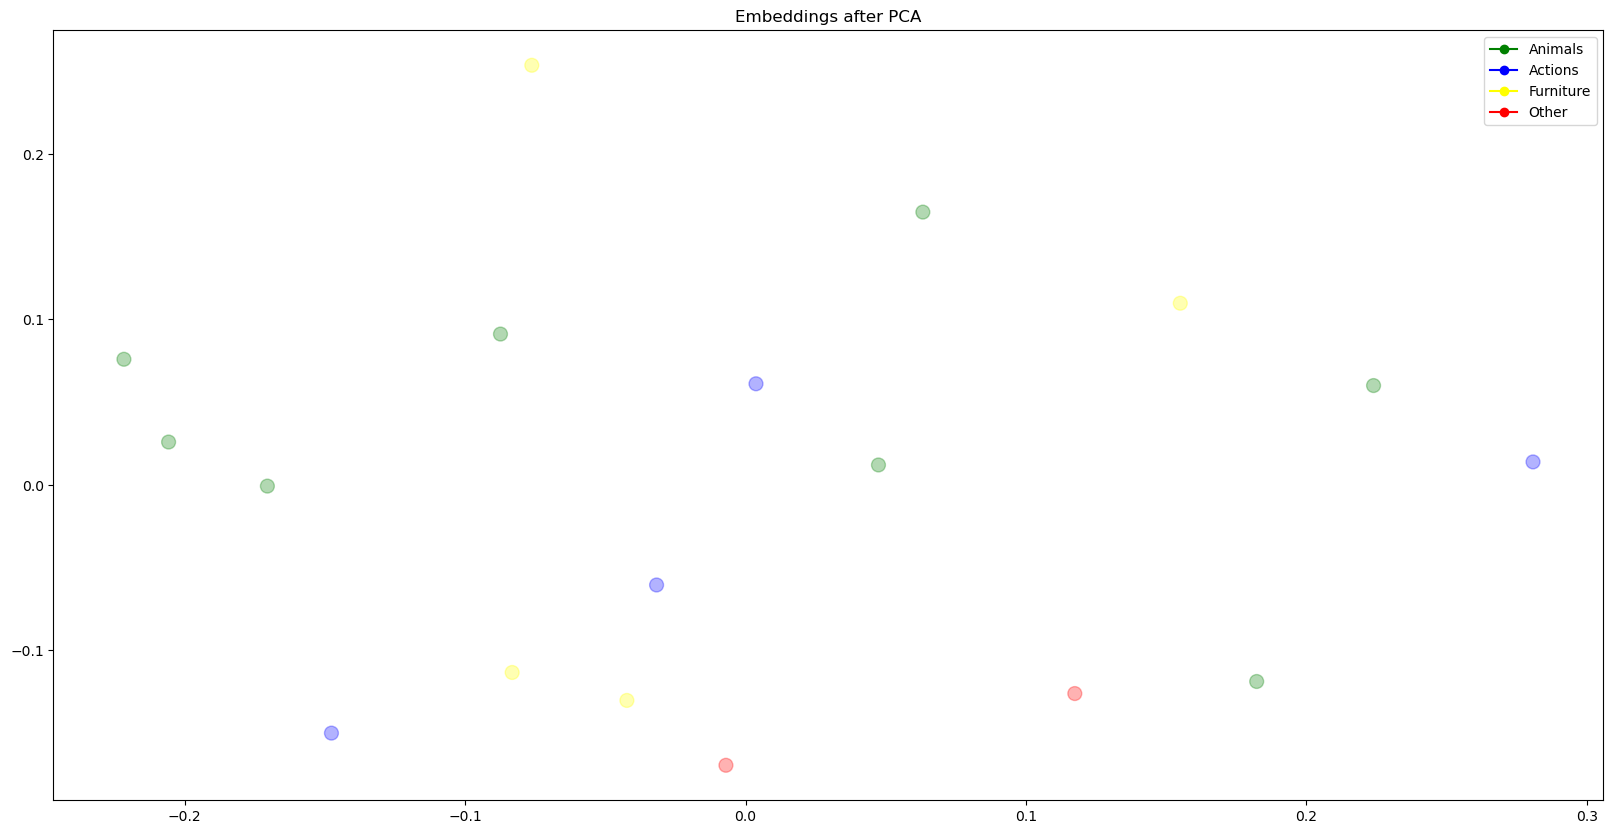

In [23]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in animal_vocab.index2token:
    index = animal_vocab.get_index(word)
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']

# Plots embeddings using PCA (you don't need to understand it)
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[:,0], vectors_pca[:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements)

# Extracting the embeddings for every word in the vocabulary, detaching them from PyTorch, and turning them into numpy
numpy_word_vectors = model.embed(torch.Tensor(range(vocabulary_size)).long()).detach().numpy()

print('The embeddings if all words in the vocabulary')
print(numpy_word_vectors)

# Display the most significant axes of the word vectors using PCA
plot_embeddings_after_pca(numpy_word_vectors)

## 3. Using pretrained embeddings

A problem with training word embeddings is that you would need to have a dataset containing all words you want to embed in many different sentences.
This adds up to needing really large datasets (the entirety of Wikipedia for example) to create good embeddings.
This is unfeasible for most people as it requires huge amounts of computational power and the ability to download and store huge datasets.
Not to mention that if everyone did this it would waste a lot of energy compared to reusing pre-trained networks.
Consequently, pre-trained embeddings created by researchers with access to large computational resources have been made publicly available.
Thus, this is an efficient way to get access to good word embeddings while saving time and energy.

We will use one such pretrained embedding network to train a network to make predictions on the AG News dataset.

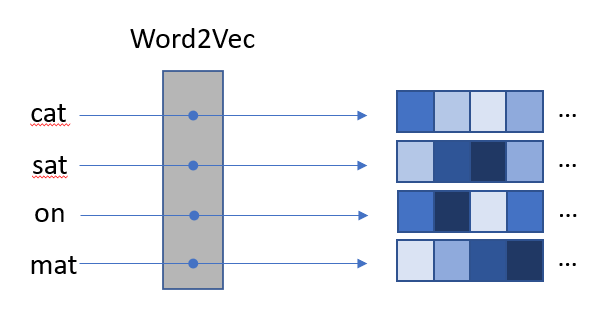


In [24]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [25]:
print(wv['horse'])

[ 5.34e-04  3.11e-02  5.04e-03 -9.18e-02 -8.36e-03 -1.66e-01  3.93e-02
  2.98e-02  1.70e-01 -2.04e-01  2.41e-01 -3.05e-01 -2.25e-02 -3.71e-01
 -5.62e-02  1.51e-01 -1.22e-01  3.42e-01  3.05e-02 -2.95e-01  6.54e-02
 -9.28e-02  1.49e-01  8.15e-02 -6.93e-02  1.98e-01 -1.66e-01  2.00e-01
  1.17e-01 -3.69e-01 -2.48e-01  1.26e-01  3.59e-01  1.51e-01 -7.76e-02
  2.91e-01 -1.75e-02 -1.21e-01 -1.00e-01  1.44e-01  5.92e-03  2.36e-02
  3.20e-01  1.83e-01  9.52e-02  9.23e-02  8.30e-02 -1.34e-01  9.57e-02
  1.67e-01  1.88e-02 -2.80e-02 -1.03e-02  1.12e-01 -8.11e-02  1.80e-01
  8.35e-02 -5.91e-02  1.71e-01  1.68e-02  8.74e-02  9.03e-02  9.23e-02
 -9.77e-02 -2.39e-02 -2.07e-01 -1.21e-02  1.45e-01  6.20e-02 -1.44e-02
  2.81e-01  6.84e-02 -2.13e-01  4.69e-02 -1.00e-01 -1.36e-01  7.47e-02
 -2.70e-01  7.57e-02 -5.52e-02 -2.01e-02 -3.81e-01  1.68e-01 -3.91e-01
  5.54e-02  2.24e-01 -6.29e-03  7.76e-02  2.03e-01 -1.05e-01 -3.12e-02
  3.54e-01  1.54e-01 -1.26e-01 -2.25e-02 -3.81e-01  3.12e-01  2.13e-01
  1.97

Word embeddings contain mathematical representations of the underlying meaning of words. As every embedding is in the same dimensions, you can utilize linear algebra to look inside how the model thinks.
Try playing around with a few words and methods to investigate how the model views language.

In [26]:
#king = wv.most_similar("king")
dist = wv.similarity("king","dog")
#print(king)
print(dist)

0.12812497


There is a famous example of embedding maths that goes "king" - "man" + "woman" = "queen". This example, and embedding maths in general, utilize the fact that embeddings are just vectors in a high dimenionsal vector space, and certain features of language tend to exist along certain axises and cluster together with similar words. We would thus expect king to have a presence in the "royalty"-axis, and in the "man"-axis. Removing man and adding woman should thus result in "royalty" + "woman", in other words a queen. See if you can find any other examples where semantic mathematics work, or an example where it clearly doesn't work. Do the results make sense to you?

In [27]:
print(wv.similar_by_vector(wv['king']))
print("")
similars = wv.similar_by_vector(wv['king']-wv['man']+wv['woman']-wv['boy']+wv['girl'])
print(similars)

similars[0]

[('king', 1.0), ('kings', 0.7138045430183411), ('queen', 0.6510957479476929), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204219460487366), ('prince', 0.6159993410110474), ('sultan', 0.5864824056625366), ('ruler', 0.5797566771507263), ('princes', 0.5646551847457886), ('Prince_Paras', 0.5432944297790527)]

[('queen', 0.7167508602142334), ('king', 0.6456761360168457), ('princess', 0.6246699690818787), ('monarch', 0.5621277689933777), ('queens', 0.5329185128211975), ('Queen_Consort', 0.5304834246635437), ('goddess', 0.5071658492088318), ('empress', 0.5053681135177612), ('very_pampered_McElhatton', 0.4988248646259308), ('prince', 0.48208680748939514)]


('queen', 0.7167508602142334)

You might be interested in investigating the vocabulary of your model

In [28]:
nr_of_words = 10
for i in range(nr_of_words):
    word = wv.index_to_key[i]
    index = wv.key_to_index[word]
    print(word)

</s>
in
for
that
is
on
##
The
with
said


### Training a FFNN with w2v


We want to train a network using our pretrained embeddings. To do this, we utilize the task and code from the AGnews-prediction with BoW, but modify it to suit our w2v-embeddings.
First we create the dataset.

In [29]:
# We create our own dataset to load the w2v embedded texts
class w2vDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], 300)
  
    def __len__(self):
        return len(self.dataset)

Then we create an embedder that encodes every word using our w2v encoder (wv.get_vector(token)).
Compared to when we used a BoW-encoder, we now face two issues: out of vocabulary (OOV) words and varying sentence length.

**Exercise 3.1:** Create a w2v-embedder using our pre-trained w2v model. <br>
**Exercise 3.1.1:** Describe three possible ways to deal with OOV-words and varying sentence length. What are the benefits and drawbacks of the methods you have described? <br>
**Exercise 3.1.2:** Implement one of these methods for OOV and varying input length to make training of a FFNN possible (your methods do not have to be good, just compileable). <br>
**Hint:** <br>
for x in range(len(tokens)): <br>
    try: # compute word2vec embedding from word. Add it to the way you store embeddings <br>
    except: # handle (or ignore) oov

In [30]:
def w2v_embedder(tensor, embedding_length):
    '''
    Takes a tensor and a embedding length and returns the w2v embedding of that tensor
    Args:
        tensor (torch.Tensor): A tensor of words represented by their index in the vocabulary
        embedding_length (int): The length of the embedding
    Returns (torch.Tensor): An tensor containing the w2v embedding of the input tensor
    '''
    ## ADD CODE HERE
    ...
    
    tensor = tensor.long()
    # Initate your embedding
    embedding = torch.zeros(embedding_length)
    # How do we get words from our tensor?
    words = tensor2text(tensor)
    # How do we get tokens from our words?
    tokens = simple_tokenizer(words)
    # What do we loop over?
    for x in range(len(tokens)):
        try:
            embedding += wv.get_vector(tokens[x])/len(tokens)
        except:
            exception = 1
            
        # How do we handle OOV?
        # How do we embed our token?
        # How do we store it?
    return embedding


Then we design and train a network

**Exercise 3.2:** Build a model that takes w2v-ecnodings of the AG-NEWS dataset as inputs and outputs AG-NEWS classes. The network might not converge towards good performance depending on your solutions to 3.1. Why?

**Hint:** Recall the BoW-classifier that we implemented and reuse that structure. <br>
Your performance might be really bad (25% accuracy). This is OK and will be amended below. 

In [31]:
w2v_train_data = w2vDataset(ag_train, w2v_embedder)
w2v_test_data = w2vDataset(ag_test, w2v_embedder)
w2v_trainloader = DataLoader(w2v_train_data, batch_size=1000, shuffle=True)
w2v_testloader = DataLoader(w2v_test_data, batch_size=1000, shuffle=False)

embedding_length = 300


## CREATE A NEURAL NETWORK TO TRAIN
#network = nn.Sequential(
#    ... # HINT: We want our input to be the size of our w2v embeddings and our output to be the different possible classes
#)

batch_nr = 1000

network = nn.Sequential(
                        nn.Linear(embedding_length, 100),
                        nn.ReLU(),
                        nn.Linear(100, 4)
                        )


# Use for instance Adam
optimizer = torch.optim.Adam(network.parameters(), lr = 0.1)

# What loss function works well when we have different classes?
loss_function = nn.CrossEntropyLoss()

epochs = 1 # The dataset is large so one epoch should do for our purpose (and anything more would take forever)

for epoch in range(epochs):
    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (labels, data) in enumerate(w2v_trainloader):
       ## WRITE TRAINING CODE HERE
       #...
    

        # Predict for each BoW represented text in the batch what class they belong to
        prediction5 = network(data)
        
        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction5, labels)
        
        # Backpropagate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()
        
        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epochs+1} [{batch_nr+1}/{len(w2v_trainloader)}] - Loss: {loss}',
            end=''
        )
        


Epoch 2 [120/120] - Loss: 0.29396635293960575

**Exercise 3.3:** Let's once again calculate accuracy and the confusion matrix.

In [32]:
with torch.no_grad():
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy, precision and recall
    for batch_nr, (labels, data) in enumerate(w2v_testloader):
        ## WRITE THE TESTING CODE HERE
        prediction6 = network(data)
        for index in range(len(prediction6)):
            if torch.argmax(prediction6[index]) == labels[index].item():
                correct += 1
            total += 1
            y_pred.append(torch.argmax(prediction6[index]).item())
            y_true.append(labels[index].item())
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

The accuracy of the network is 89.2%.


Confusion matrix, without normalization
[[1676   69  102   53]
 [  26 1858   11    5]
 [  82   26 1597  195]
 [  67   26  157 1650]]


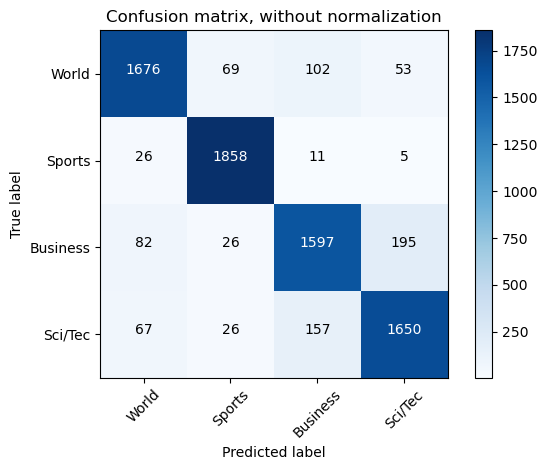

In [33]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')

Let us also investigate how the pretrained embeddings separate the animals, actions and furnitures from our initial corpus. You can also insert any words from the word2vec corpus (wv.vocab) here and see how they are projected in a 2D-space using PCA.

The embeddings if all words in the vocabulary
[[ 0.08  0.1   0.05 ...  0.    0.05 -0.07]
 [ 0.01  0.2  -0.29 ...  0.49 -0.28  0.06]
 [ 0.2   0.08  0.15 ... -0.04  0.17 -0.01]
 ...
 [-0.09 -0.1  -0.49 ...  0.02  0.08  0.  ]
 [ 0.    0.35 -0.32 ...  0.35 -0.1   0.23]
 [-0.06  0.14 -0.34 ...  0.15 -0.01  0.17]]


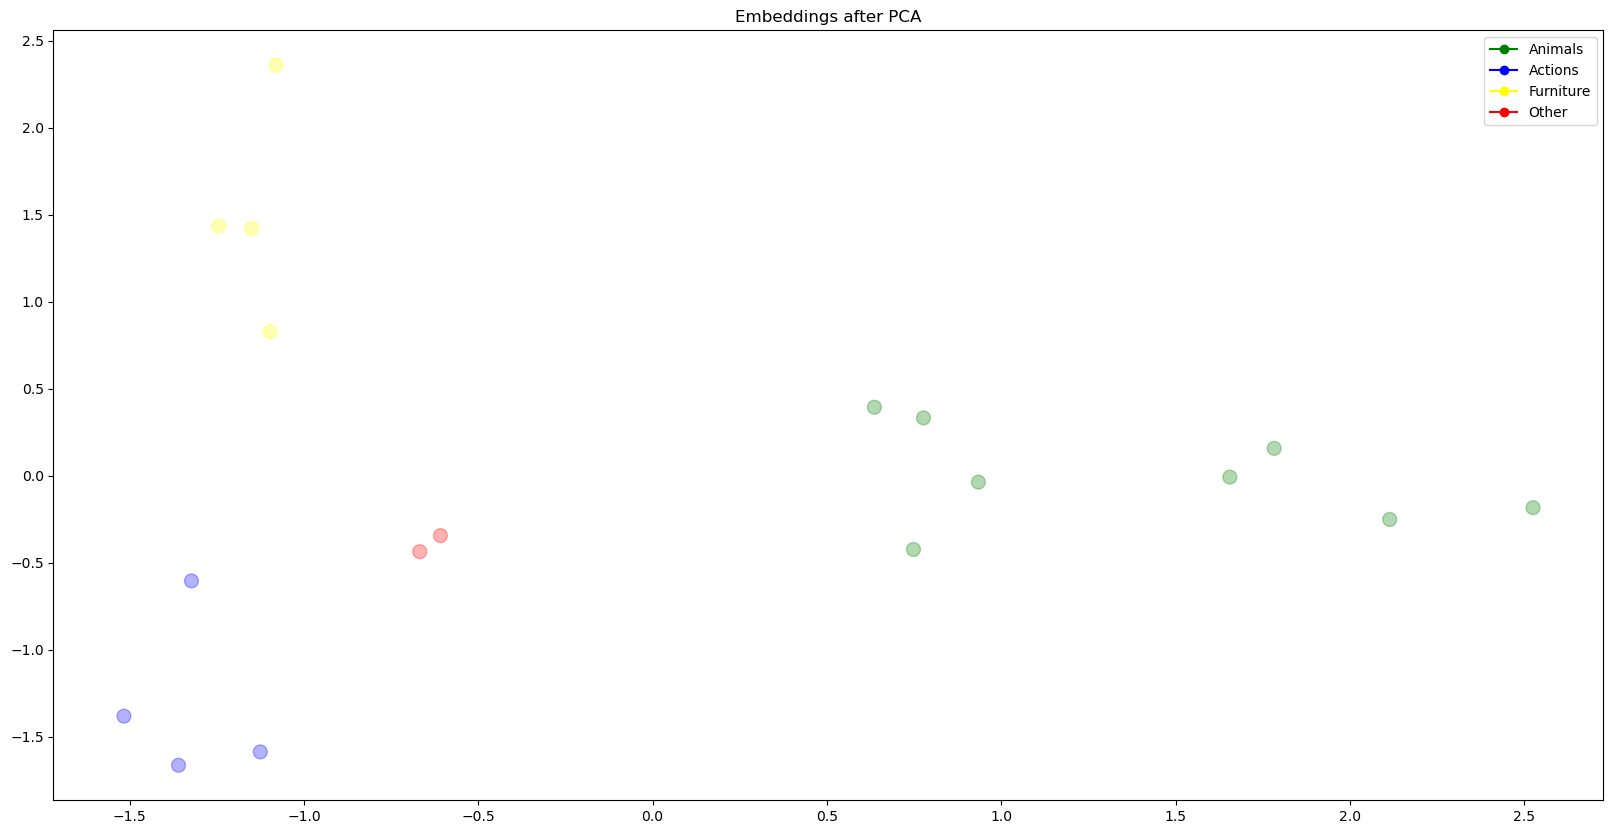

In [34]:
#%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

numpy_word_vectors = numpy.zeros([18,300])

category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in animal_vocab.index2token:
    index = animal_vocab.get_index(word)
    numpy_word_vectors[index,:] = wv[word]
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']

# Plots embeddings using PCA (you don't need to understand it)
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[:,0], vectors_pca[:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

# Extracting the embeddings for every word in the vocabulary, detaching them from PyTorch, and turning them into numpy


print('The embeddings if all words in the vocabulary')
print(numpy_word_vectors)

# Display the most significant axes of the word vectors using PCA
plot_embeddings_after_pca(numpy_word_vectors)

We see that despite spanning 300 million words, animals, actions and furnitures are all separated by the model, with animals being the most spread out of the three.

## 4. Recurrent Neural Networks

As a final task, let us use embeddings where they are really matter, in recurrent neural networks (RNNs) (or Transformers, but that's a topic for another course). RNNs are covered in the first lecture in ANN3, but consider this a teaser where you don't yet need to understand the inner workings of the black box.

<a title="fdeloche, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Recurrent_neural_network_unfold.svg"><img width="512" alt="Recurrent neural network unfold" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/512px-Recurrent_neural_network_unfold.svg.png"></a>

RNNs have a major benefit in that they can use input sequences of any length in the same network. When using BoW, our encodings collapsed to the same dimensions, but with w2v we faced the challenge of having varying input dimensions. In RNNs, our input is fed sequentially to the network together with the previous network output. After our first input token is transformed to a prediction, this prediction is fed to the same network together with the next token, until all tokens have been seen. Thus, regardless of if our input sequence is one word or 100 words, the network size remains the same (but for 100 words we will have to backprop 100 times through the network to train it. What issues might this cause?).

We shall now implement another w2v embedder, this time maintaining the sequential structure of our data. But first, let's make a third dataset class.


In [35]:
# We create our own dataset to load the w2v embedded texts
class rnnDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], 300)
  
    def __len__(self):
        return len(self.dataset)

**Exercise 4.1:** Implement an emedder for rnnDataset which takes an input tensor, transforms it to words->tokens->embeddings, then stores the embeddings while maintainin the structural integrity of the original sentences. <br>
**Hint:** The embedder should be quite similar to w2v-embedder. Consider using numpy.shape() to investigate the shape of your dataset and remember that you can go from list to numpy.array with numpy.asarray(). <br>
You don't necessarily need the embedding length since we create sequences of embeddings

In [36]:
def rnn_embedder(tensor, embedding_length):
    '''
    Takes a tensor and a embedding length and returns a sequence of the w2v embeddings of each token in that tensor
    Args:
        tensor (torch.Tensor): A tensor of words represented by their index in the vocabulary
        embedding_length (int): The length of the embedding
    Returns (torch.Tensor): An tensor containing the w2v embeddings of the input tensor
    '''
    
    ## ADD CODE HERE
    ...
    
    tensor = tensor.long()
    # Initate your embedding
    embedding = torch.zeros(embedding_length)
    # How do we get words from our tensor?
    words = tensor2text(tensor)
    # How do we get tokens from our words?
    tokens = simple_tokenizer(words)
    # What do we loop over?
    for x in range(len(tokens)):
        try:
            embedding += wv.get_vector(tokens[x])
        except:
            exception = 1
        # How do we handle OOV?
        # How do we embed our token?
        # How do we store it sequentially?
    return embedding

   

We shall now design an LSTM network. When implementing machine learning models, one often has to consult the root documentation. Let us therefore go to https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html to study the input, hidden and output sizes of the torch.nn.LSTM class.

**Exercise 4.2:** Finish the implementation of our LSTM network class. <br>
**Hint:** Don't miss the batch_first=True command when looking at batch size or sequence length first. <br>
Defining the init and the forward 

In [37]:
from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #nr of classes
        self.num_layers = num_layers #nr of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        ## TASK: Insert the correct dimensions for our LSTM and FC layers
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True) # LSTM layer
        self.fc_1 =  nn.Linear(hidden_size, 128) #fFirst FC layer
        self.fc = nn.Linear(128, num_classes) # Final FC layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(
                                   self.num_layers,
                                   x.size(0),
                                   self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(
                                   self.num_layers,
                                   x.size(0),
                                   self.hidden_size)) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [38]:
num_epochs = 2 #2 epochs
learning_rate = 0.001 #0.001 lr


input_size = 300 #number of features
hidden_size = 50 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
sequence_length = input_size
num_classes = len(ag_labels)
device=torch.device('cpu')

lstm1 = LSTM1(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, 
              num_layers=num_layers, seq_length=sequence_length) #our lstm class

Using our LSTM class and RNN dataloader, let's train out network and see how well it works.

**Exercise 4.3:** Train the network to reach an accuracy of over 90%. <br>
**Hint:** Consider starting with batch size = 1 or else data will have multiple sequence lengths. <br>
Use torch.from_numpy to convert a numpy array to torch

In [39]:
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

rnn_train_data = rnnDataset(ag_train, rnn_embedder)
rnn_test_data = rnnDataset(ag_test, rnn_embedder)
rnn_trainloader = DataLoader(rnn_train_data, batch_size=1, shuffle=True)
rnn_testloader = DataLoader(rnn_test_data, batch_size=1, shuffle=False)


Let's once again calculate accuracy and the confusion matrix.
**Exercise 4.4:** Calculate accuracy and confusion matrix. How well does your network perform? What could you do to improve accuracy further (you don't have to implement it)?

In [40]:
with torch.no_grad():
    classes = [0, 1, 2, 3]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    # For each batch of testing data (since the dataset is too large to run all data through the network at once)
    # Calculate the accuracy, precision and recall
    for batch_nr, (labels, data) in enumerate(rnn_testloader):
        ## WRITE THE TESTING CODE HERE
        prediction7 = network(data)
        for index in range(len(prediction7)):
            if torch.argmax(prediction7[index]) == labels[index].item():
                correct += 1
            total += 1
            y_pred.append(torch.argmax(prediction7[index]).item())
            y_true.append(labels[index].item())
        ...

            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

The accuracy of the network is 89.0%.


Confusion matrix, without normalization
[[1676   71  105   48]
 [  26 1859   10    5]
 [  77   30 1621  172]
 [  72   28  185 1615]]


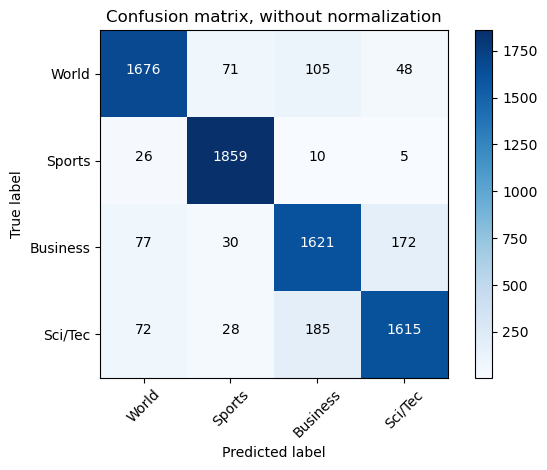

In [41]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1, 2, 3])
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['World', 'Sports', 'Business', 'Sci/Tec'],
                      title='Confusion matrix, without normalization')

You have now reached the end of exercise 2. Well done!